<a href="https://colab.research.google.com/github/cruzjulio10/AST/blob/master/Copia_de_Healthcare_AI_JCML_PLANTILLA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TAREA #1: ENTENDER EL ENUNCIADO DEL PROBLEMA Y EL CASO PRÁCTICO
    

In [1]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

![alt text](https://drive.google.com/uc?id=1GAWfaucw0yYWOvVFHCvPUAIe87sqRxAd)

![alt text](https://drive.google.com/uc?id=1mR5yqG3DTryYlUELiGKn4GBaSmEZng_-)

![alt text](https://drive.google.com/uc?id=15G1y2Cs6nHtdM25gfwjyKDpGwVr7A10_)

- Fuente original: https://www.kaggle.com/mateuszbuda/lgg-mri-segmentation
- Clickable link for the full list of startups in AI medical imagery: https://research.aimultiple.com/looking-for-better-medical-imaging-for-early-diagnostic-and-monitoring-contact-the-leading-vendors-here/

![alt text](https://drive.google.com/uc?id=1aq_9XV_rX7DCNXPGMkMh8QLRnMmdDcD_)

![alt text](https://drive.google.com/uc?id=1CMPW0u1Lq5aNrJX3uffBIrLAoPOtUTtE)

![alt text](https://drive.google.com/uc?id=1uP9hs79W-1yTLVbEKdLMdi7Bb4c1HN9P)

# TAREA #2: IMPORTAR LIBRERÍAS Y DATASETS

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
import os
import glob
import random
from google.colab import files #Librería para cargar ficheros directamente en Colab
%matplotlib inline

In [ ]:
# Necesitaremos montar su disco usando los siguientes comandos:
# Para obtener más información sobre el montaje, puedes consultar: https://stackoverflow.com/questions/46986398/import-data-into-google-colaboratory

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Navegamos hasta el directorio My Drive para almacenar el conjunto de datos y herramientas adicionales
%cd /content/drive/My Drive/Healthcare AI Datasets/Brain_MRI


/content/drive/My Drive/Healthcare AI Datasets/Brain_MRI


In [ ]:
# Datos que contienen la ruta a Brain MRI y su máscara correspondiente
brain_df = pd.read_csv('data_mask.csv')

![alt text](https://drive.google.com/uc?id=1UhYwK8wILbDn2DhXExrpZz_i5oXTbIp6)

In [ ]:
brain_df.info()

In [ ]:
brain_df.head(50)

In [ ]:
brain_df.mask_path[1] # Ruta a la máscara de segmentación

In [ ]:
brain_df.image_path[1] # Ruta a la imagen de la MRI

MINI RETO #1:
  - ¿Tenemos un dataset balanceado?
  - ¿Cuantas muestras están marcadas como 'paciente sano'?

In [ ]:
brain_df['mask'].value_counts() # 0 pacientes sanos y 1 Pacientes enfermos

# TAREA #3: VISUALIZACIÓN DE DATOS

In [ ]:
brain_df

In [ ]:
# Usaremos plotly para hacer un diagrama de barras interactivo
import plotly.graph_objects as go

fig = go.Figure([go.Bar(x = brain_df['mask'].value_counts().index, y = brain_df['mask'].value_counts())])
fig.update_traces(marker_color = 'rgb(0,200,0)', marker_line_color = 'rgb(0,255,0)',
                  marker_line_width = 7, opacity = 0.6)
fig.show()

In [ ]:
brain_df['mask'].value_counts().index

Index([0, 1], dtype='int64', name='mask')

In [ ]:
brain_df.mask_path

0       TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...
1       TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...
2       TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...
3       TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...
4       TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...
                              ...                        
3924    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...
3925    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...
3926    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...
3927    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...
3928    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...
Name: mask_path, Length: 3929, dtype: object

In [ ]:
brain_df.image_path

0       TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif
1       TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif
2       TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif
3       TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif
4       TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif
                              ...                        
3924    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_86...
3925    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_87...
3926    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_87...
3927    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_88...
3928    TCGA_HT_A61B_19991127/TCGA_HT_A61B_19991127_88...
Name: image_path, Length: 3929, dtype: object

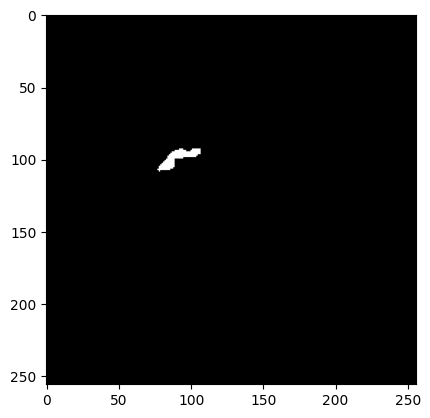

In [ ]:
plt.imshow(cv2.imread(brain_df.mask_path[623]))

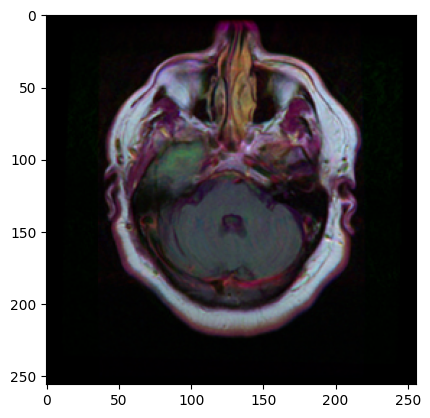

In [ ]:
plt.imshow(cv2.imread(brain_df.image_path[623]))

In [ ]:
cv2.imread(brain_df.mask_path[623]).max()

255

In [ ]:
cv2.imread(brain_df.mask_path[623]).min()

0

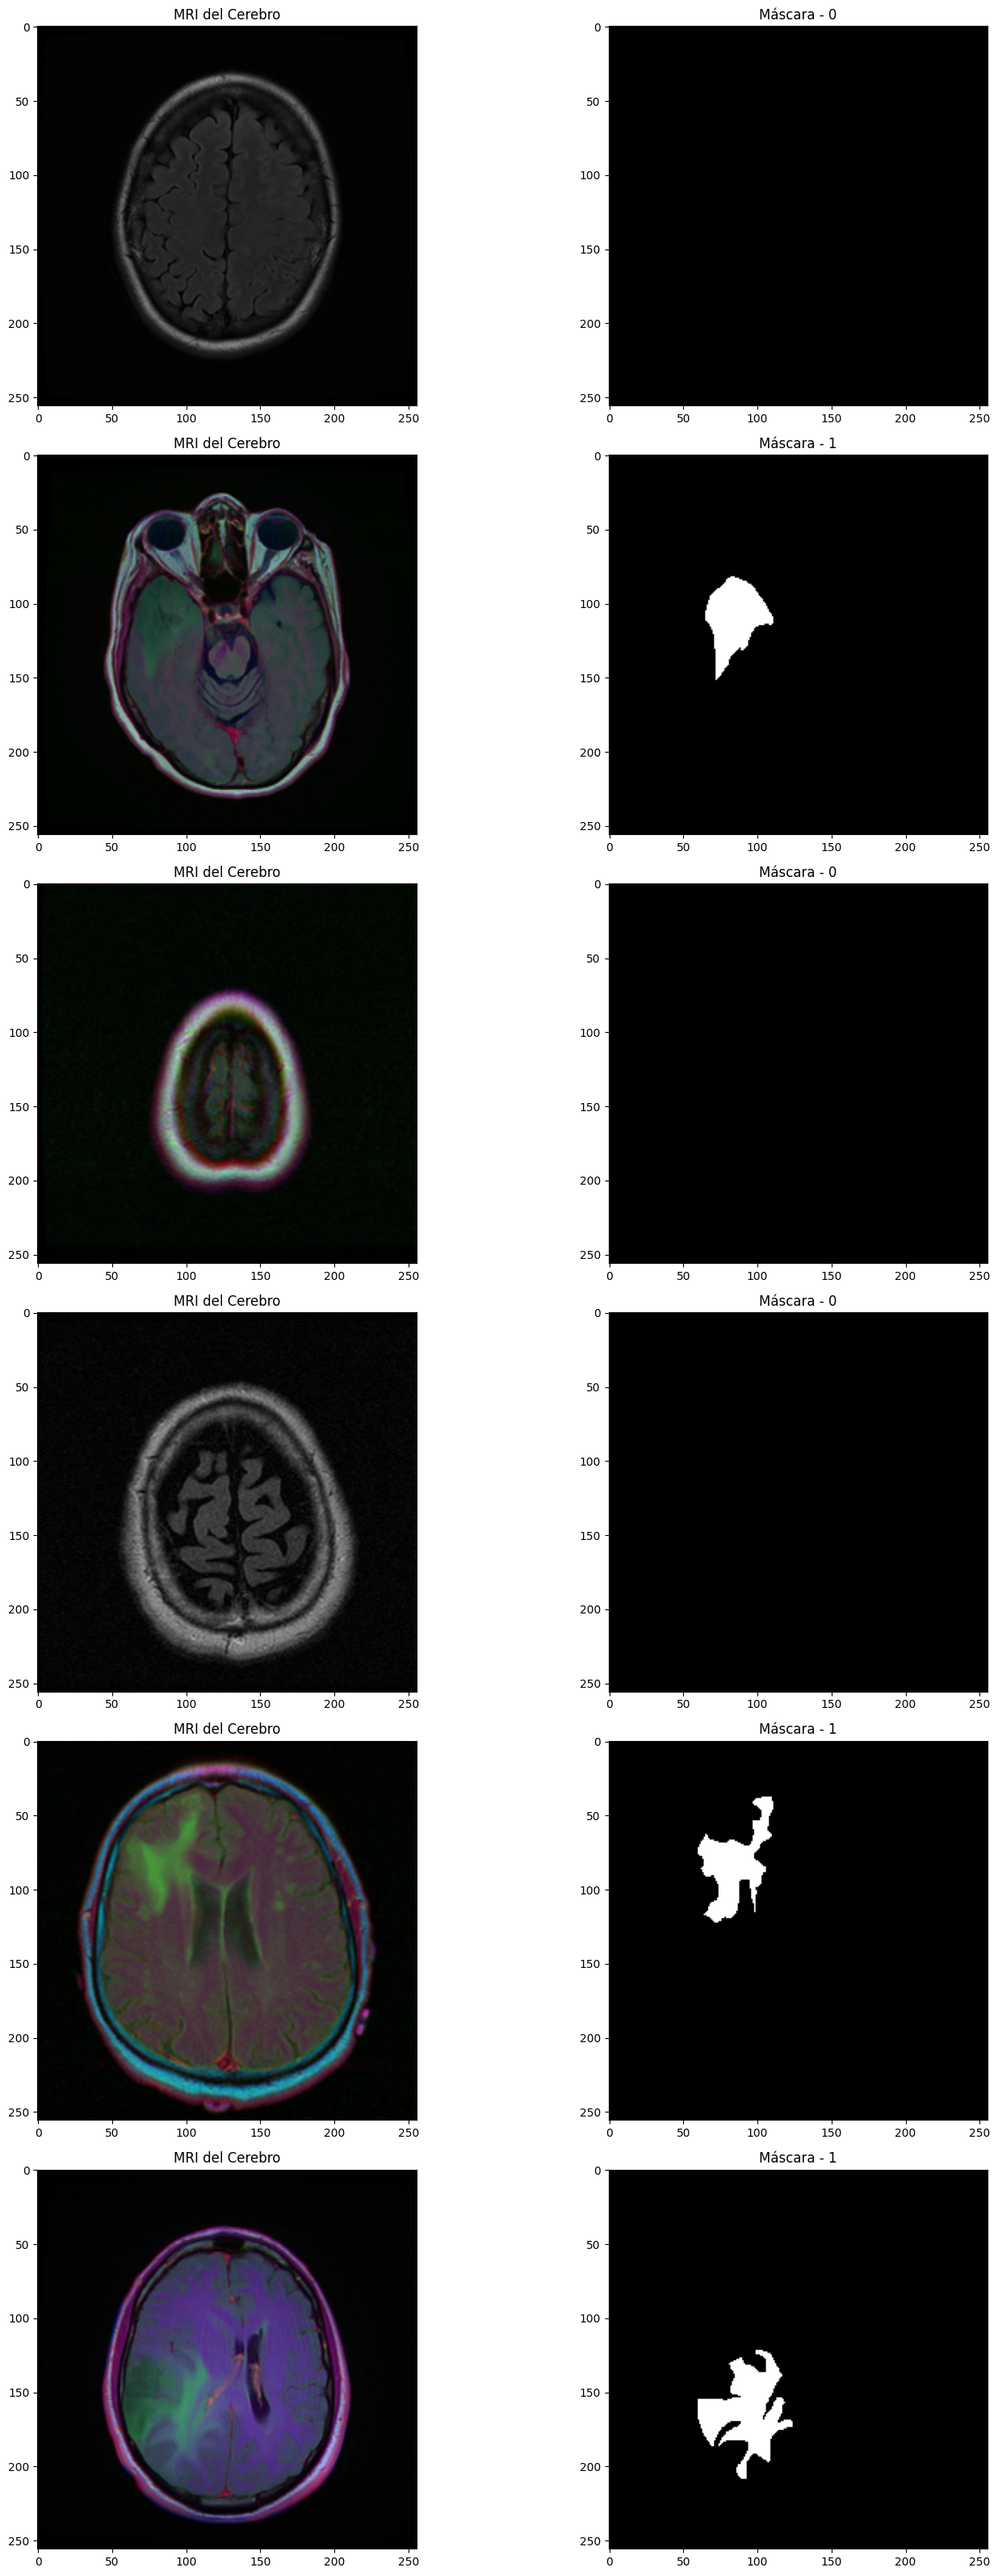

In [ ]:
# Visualización básica Visualizaremos imágenes (MRI y Máscaras) en el dataset de forma separada
import random
fig, axs = plt.subplots(6,2, figsize=(16,32))
count = 0
for x in range(6):
  i = random.randint(0, len(brain_df)) # Seleccionamos un índice aleatorio
  axs[count][0].title.set_text("MRI del Cerebro") # Configuramos el título
  axs[count][0].imshow(cv2.imread(brain_df.image_path[i])) # Mostramos la MRI
  axs[count][1].title.set_text("Máscara - " + str(brain_df['mask'][i])) # Colocámos el título en la máscara (0 o 1)
  axs[count][1].imshow(cv2.imread(brain_df.mask_path[i])) # Mostramos la máscara correspondiente
  count += 1

fig.tight_layout()

MINI RETO #2:
 - Representar aleatoriamente 12 (1) imágenes de  MRI seleccionadas aleatoriamente de entre los pacientes enfermos seguidas de (2) su correspondiente máscara, (3) tanto la imágen de la MRI junto con su máscara (de color rojo) una encima de la otra.

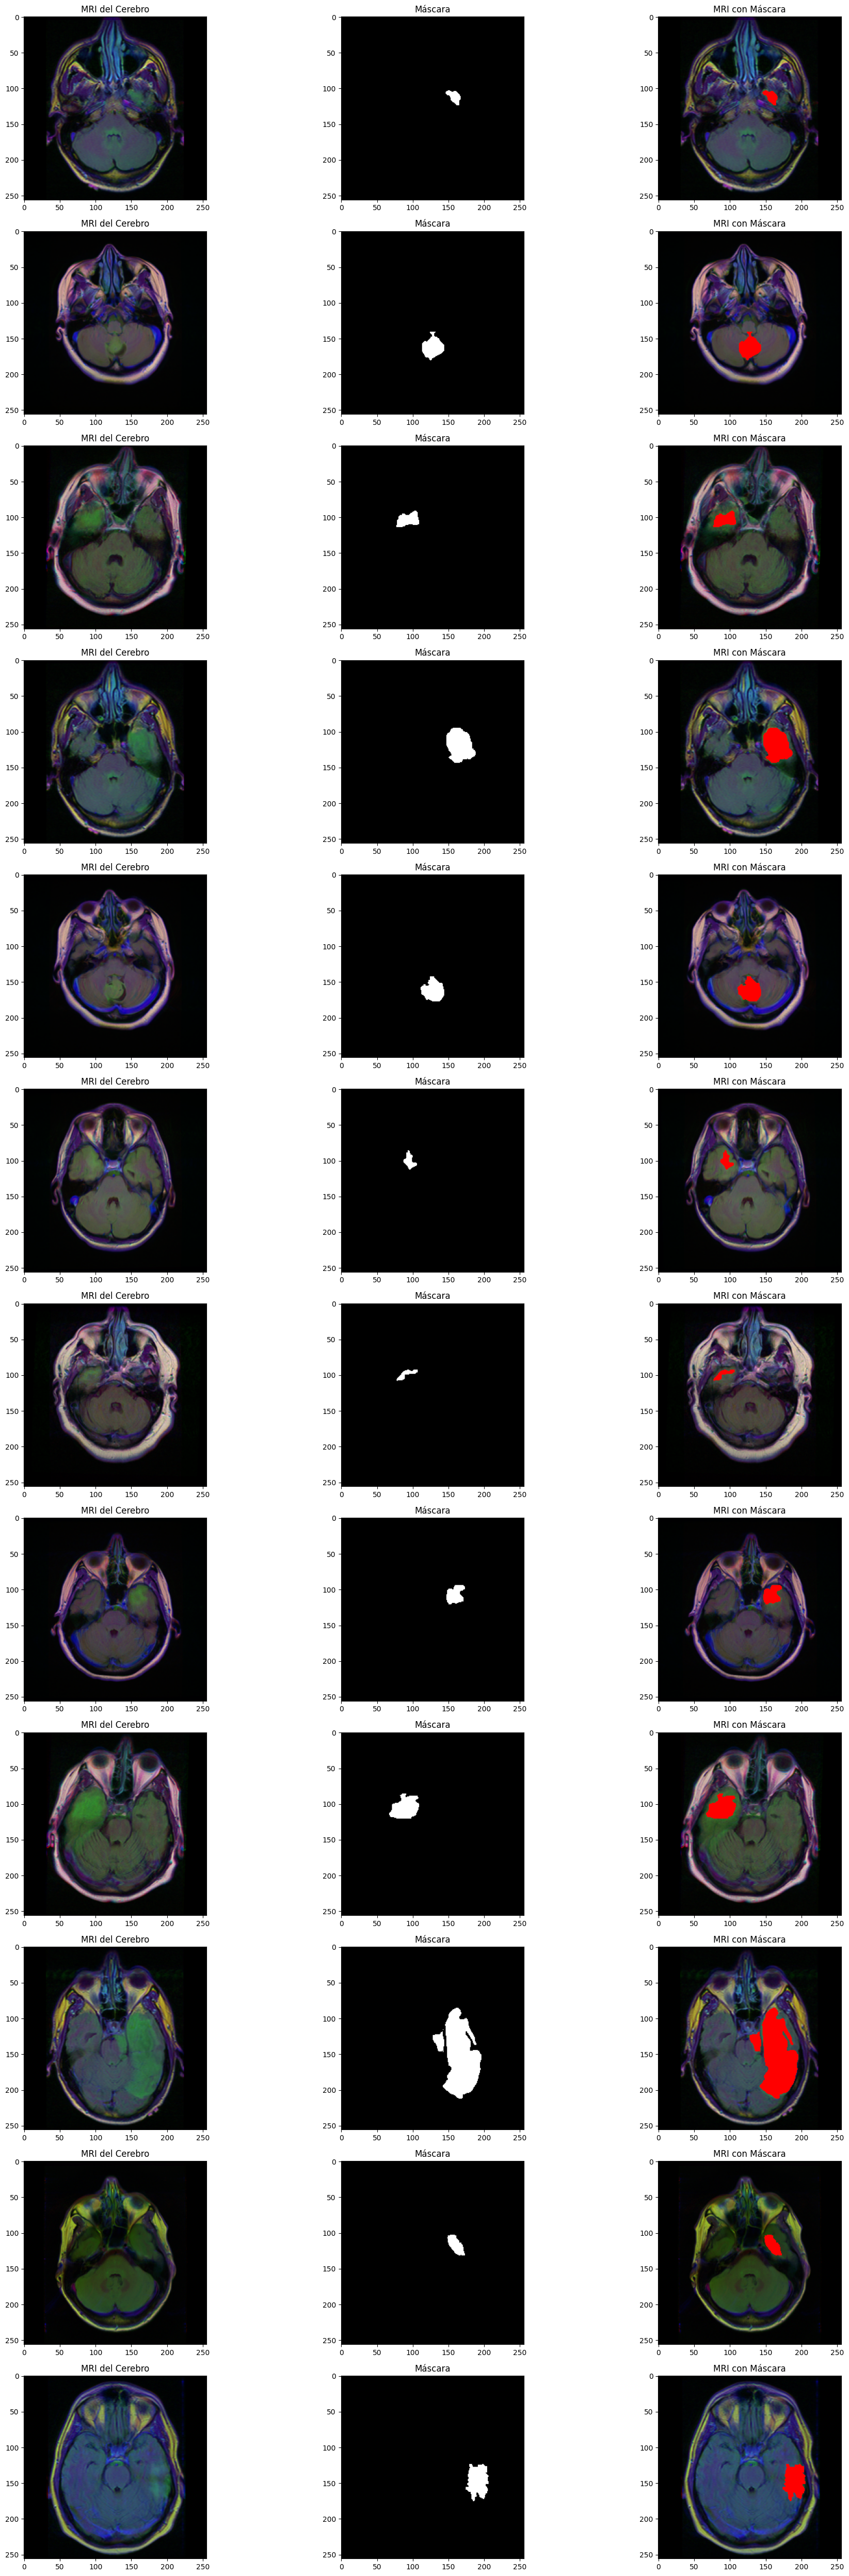

In [ ]:
count = 0
fig, axs = plt.subplots(12, 3, figsize = (20, 50))
for i in range(len(brain_df)):
  if brain_df['mask'][i] ==1 and count <12:
    img = io.imread(brain_df.image_path[i])
    axs[count][0].title.set_text('MRI del Cerebro')
    axs[count][0].imshow(img)

    mask = io.imread(brain_df.mask_path[i])
    axs[count][1].title.set_text('Máscara')
    axs[count][1].imshow(mask, cmap = 'gray')

    # Se toma la imagen original y para las posiciones donde la máscara tiene un valor de 255,
    # En posición para filas y columnas, se reemplaza el valor que tuviera en esa zona del cerebro de la resonancia magnética
    # Un lugar con un blanco o un gris, como la escala de grisis que se ha pintado la máscara, se pone color rojo
    # en tupla 255 en rojo, 0 en verde, y 0 en azul



    img[mask == 255] = (255, 0, 0)
    axs[count][2].title.set_text('MRI con Máscara')
    axs[count][2].imshow(img)
    count+=1

fig.tight_layout()


# TAREA #4: ENTENDER LA TEORÍA Y LA INTUICIÓN DETRÁS DE LAS REDES NEURONALES Y RESNETS CONVOLUCIONALES

![alt text](https://drive.google.com/uc?id=1Y9hpqFFGAIXtzVmHi49zCIYTERrff1K3)

- Feature Extraction and Convolutions: https://setosa.io/ev/image-kernels/
- CNN Visualization: https://www.cs.ryerson.ca/~aharley/vis/conv/flat.html


![alt text](https://drive.google.com/uc?id=1nf65LNkurgUBqx8kU00FIgInMwHkJmR2)

- Link al paper de ResNets (Deep Residual Learning for Image Recognition): https://arxiv.org/pdf/1512.03385.pdf

MINI RETO #3:
- ¿Cuál es el rendimiento de ResNet en el conjunto de datos ImageNet?
- Explora otras arquitecturas de RNC como AlexNet y enumera su rendimiento en comparación con ResNet (se requiere investigación externa)

# TAREA # 5: ENTENDER LA TEORÍA Y LA INTUICIÓN DETRÁS DEL APRENDIZAJE POR TRANSFERENCIA

![alt text](https://drive.google.com/uc?id=1Xj4c5U-cRQVnv38J_i-3J9IOHA0EG1nb)

![alt text](https://drive.google.com/uc?id=1fnfO27T6vlR0rWTPj41sm5fDwZXXo0Gs)

![alt text](https://drive.google.com/uc?id=1316MR8iufOwjiJD6vk9vIgwtepLNNCE0)

- Excelente recurso sobre transferencia de aprendizaje por Dipanjan Sarkar: https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a
- Artículo de Jason Brownlee: https://machinelearningmastery.com/transfer-learning-for-deep-learning/

MINI RETO #4:
- Enumere los desafíos del aprendizaje por transferencia (se requiere investigación externa)

# TAREA # 6: ENTRENAR UN MODELO CLASIFICADOR PARA DETECTAR SI EXISTE TUMOR O NO

In [ ]:
# Eliminamos la columna de identificador del paciente
brain_df_train = brain_df.drop(columns = ['patient_id'])
brain_df_train.shape

(3929, 3)

In [ ]:
# Convertir los datos en la columna de máscara a formato de string, para usar el modo categórico en flow_from_dataframe
# Verás este mensaje de error si comentad la siguiente línea de código:
# TypeError: If class_mode="categorical", y_col="mask" column values must be type string, list or tuple.
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))

In [ ]:
brain_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_path  3929 non-null   object
 1   mask_path   3929 non-null   object
 2   mask        3929 non-null   object
dtypes: object(3)
memory usage: 92.2+ KB


In [ ]:
# Dividir los datos en entrenamiento y testing

from sklearn.model_selection import train_test_split

train, test = train_test_split(brain_df_train, test_size = 0.15)

In [ ]:
!pip install Keras-Preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.5 MB/s eta 0:00:00


In [ ]:
# Creamos el generador de imágenes
from keras_preprocessing.image import ImageDataGenerator

# Creamos un generador de datos que escale los datos de 0 a 1 y haga una división de validación de 0,15
# Re escala todos los píxeles se dividen entre 255 #
datagen = ImageDataGenerator(rescale=1./255., validation_split = 0.15)


In [ ]:
train_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="training",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))


valid_generator=datagen.flow_from_dataframe(
dataframe=train,
directory= './',
x_col='image_path',
y_col='mask',
subset="validation",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=(256,256))

# Creamos un generador de datos para imágenes de prueba
test_datagen=ImageDataGenerator(rescale=1./255.)
# Como es de test ya no es necesario la aleatoridad shuffle falso
test_generator=test_datagen.flow_from_dataframe(
dataframe=test,
directory= './',
x_col='image_path',
y_col='mask',
batch_size=16,
shuffle=False,
class_mode='categorical',
target_size=(256,256))

Found 2839 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


In [ ]:
# Ahora aplicamos modelo de aprendizaje por transferencia
# Obtenemos el modelo base de ResNet50 (red neuronal), que ya está totalmente entrenada con una arquitectura, una serie de pesos y demás.
# Y la idea es el poder utilizar el aprendizaje por transferencia para traerla a mi espacio de trabajo,
# voy a descargar una red neuronal masiva ya entrenada, con millones de datos
# ya hay muchas conexiones en esa red neuronal. Ya es capaz de detectar muchas características.
# los detectores de características y los kernel ya están preparados y nosotros lo que vamos a hacer es
# descargarnos esa ResNet50 con los pesos de entrenamiento utilizados sobre el conjunto de datos de match net.
# En cuanto a la propiedad "include_top"=false pq no queremos la última capa que clasifica las imágenes
basemodel = ResNet50(weights = 'imagenet', include_top = False, input_tensor = Input(shape=(256, 256, 3)))

94765736/94765736 [==============================] - 3s 0us/step


In [ ]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [ ]:
# Congelamos los pesos del modelo

for layer in basemodel.layers:
  layers.trainable = False

In [ ]:
# Agregamos una cabecera de clasificación al modelo base

headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
#headmodel = Dense(256, activation = "relu")(headmodel)
#headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(2, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [ ]:
# Compilamos el modelo

model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [ ]:
# Utilizamos la parada temprana para salir del entrenamiento si la pérdida en la validación no disminuye incluso después de ciertas épocas (paciencia)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# Guardamos el mejor modelo con la menor pérdida de validación
checkpointer = ModelCheckpoint(filepath="classifier-resnet-weights.hdf5", verbose=1, save_best_only=True)

In [ ]:
history = model.fit(train_generator, steps_per_epoch= train_generator.n // 16, epochs = 1, validation_data= valid_generator, validation_steps= valid_generator.n // 16, callbacks=[checkpointer, earlystopping])

177/177 [==============================] - ETA: 0s - loss: 0.7848 - accuracy: 0.6876 
Epoch 1: val_loss improved from inf to 0.64992, saving model to classifier-resnet-weights.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



177/177 [==============================] - 3372s 19s/step - loss: 0.7848 - accuracy: 0.6876 - val_loss: 0.6499 - val_accuracy: 0.6694


In [ ]:
# Guardamos la arquitectura del modelo en un archivo json para uso futuro

model_json = model.to_json()
with open("classifier-resnet-model.json","w") as json_file:
  json_file.write(model_json)

MINI RETO #5:
- Cambia la arquitectura de la red agregando capas, neuronas o Dropouts más / menos densos.
- Imprime el resumen del modelo y compara el número total de parámetros entrenables entre el modelo original y el nuevo

In [ ]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(2, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [ ]:
model.summary()

# TAREA # 7: EVALUA EL RENDIMIENTO DEL MODELO ENTRENADO

In [ ]:
# Cargamos el modelo preentrenado (en lugar de entrenar el modelo durante más de 1 hora)
with open('resnet-50-MRI.json', 'r') as json_file:
    json_savedModel= json_file.read()
# Cargar el modelo
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('weights.hdf5')
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics= ["accuracy"])

In [ ]:
# Hacemos la predicción

test_predict = model.predict(test_generator, steps = test_generator.n // 16, verbose =1)

36/36 [==============================] - 347s 10s/step


In [ ]:
test_predict.shape

In [ ]:
test_predict

In [ ]:
# Obtenemos la clase predicha a partir del modelo
predict = []

for i in test_predict:
  predict.append(str(np.argmax(i)))

predict = np.asarray(predict)

In [ ]:
predict

In [ ]:
# Dado que usamos el generador de prueba, se limita el número de imágenes a leer (predecir), debido al tamaño del lote
original = np.asarray(test['mask'])[:len(predict)]
len(original)

In [ ]:
# Obtenemos la tasa de acierto del modelo
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(original, predict)
accuracy

In [ ]:
# Representamos la matriz de confusión
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(original, predict)
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot=True)

MINI RETO #6:
- Imprime el informe de clasificación y comenta sobre los resultados de precisión, recuperación y F1-Score

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(original, predict, labels = [0,1])
print(report)

# TAREA # 8: ENTENDER LA TEORÍA Y LA INTUICIÓN DETRÁS DE LOS MODELOS RESUNET

![alt text](https://drive.google.com/uc?id=1lspkqnFswwigkI9w1xR_GIyDOBtJztY4)

![alt text](https://drive.google.com/uc?id=1dEqVh2vxL1KBvA2gIM9XgBySDW31m34z)

![alt text](https://drive.google.com/uc?id=1zOR3-sqfZq3bbisvjtAaR7q0v8UGCFKW)

![alt text](https://drive.google.com/uc?id=1XTes0Qtr-wu9NLSIfg9MfE83TrKmFxEH)

![alt text](https://drive.google.com/uc?id=136tXXjGs4NCn6_mHzr7JRzKr_8ro-tBy)

# TAREA # 9: CONSTRUIR UN MODELO DE SEGMENTACIÓN PARA LOCALIZAR EL TUMOR

In [ ]:
# Obtenemos el dataframe que contiene las resonancias magnéticas que tienen máscaras asociadas.
brain_df_mask = brain_df[brain_df['mask'] == 1]
brain_df_mask.shape

In [ ]:
# Dividir los datos en datos de prueba y de tren

from sklearn.model_selection import train_test_split

X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_test, X_val = train_test_split(X_val, test_size=0.5)

In [ ]:
# Crear una lista separada para imageId, classId para pasar al generador

train_ids = list(X_train.image_path)
train_mask = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_mask= list(X_val.mask_path)

In [ ]:
# El archivo de utilidades contiene el código para la función de pérdida personalizada y el generador de datos personalizados
from utilities import DataGenerator

# Creamos los generadores de imágenes

training_generator = DataGenerator(train_ids,train_mask)
validation_generator = DataGenerator(val_ids,val_mask)

In [ ]:
def resblock(X, f):


  # Hacemos la copia de la entrada
  X_copy = X

  # Ruta principal
  # Más acerca de he_normal: https://medium.com/@prateekvishnu/xavier-and-he-normal-he-et-al-initialization-8e3d7a087528

  X = Conv2D(f, kernel_size = (1,1) ,strides = (1,1),kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)

  X = Conv2D(f, kernel_size = (3,3), strides =(1,1), padding = 'same', kernel_initializer ='he_normal')(X)
  X = BatchNormalization()(X)

  # Ruta corta
  # Más sobre esto en: https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33

  X_copy = Conv2D(f, kernel_size = (1,1), strides =(1,1), kernel_initializer ='he_normal')(X_copy)
  X_copy = BatchNormalization()(X_copy)

    # Agregar la salida de la ruta principal y la ruta corta juntas

  X = Add()([X,X_copy])
  X = Activation('relu')(X)

  return X

In [ ]:
# Función para escalar y concatenar los valores pasados
def upsample_concat(x, skip):
  x = UpSampling2D((2,2))(x)
  merge = Concatenate()([x, skip])

  return merge

In [ ]:
input_shape = (256,256,3)

# Forma del tensor de entrada
X_input = Input(input_shape)

# Fase 1
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(X_input)
conv1_in = BatchNormalization()(conv1_in)
conv1_in = Conv2D(16,3,activation= 'relu', padding = 'same', kernel_initializer ='he_normal')(conv1_in)
conv1_in = BatchNormalization()(conv1_in)
pool_1 = MaxPool2D(pool_size = (2,2))(conv1_in)

# Fase 2
conv2_in = resblock(pool_1, 32)
pool_2 = MaxPool2D(pool_size = (2,2))(conv2_in)

# Fase 3
conv3_in = resblock(pool_2, 64)
pool_3 = MaxPool2D(pool_size = (2,2))(conv3_in)

# Fase 4
conv4_in = resblock(pool_3, 128)
pool_4 = MaxPool2D(pool_size = (2,2))(conv4_in)

# Fase 5 (Cuello de Botella)
conv5_in = resblock(pool_4, 256)

# Fase de Escalada 1
up_1 = upsample_concat(conv5_in, conv4_in)
up_1 = resblock(up_1, 128)

# Fase de Escalada 2
up_2 = upsample_concat(up_1, conv3_in)
up_2 = resblock(up_2, 64)

# Fase de Escalada 3
up_3 = upsample_concat(up_2, conv2_in)
up_3 = resblock(up_3, 32)

# Fase de Escalada 4
up_4 = upsample_concat(up_3, conv1_in)
up_4 = resblock(up_4, 16)

# Salida Final
output = Conv2D(1, (1,1), padding = "same", activation = "sigmoid")(up_4)

model_seg = Model(inputs = X_input, outputs = output )


MINI RETO #7:
- Imprime el resumen del modelo de segmentación y enumera el número total de parámetros entrenables

In [ ]:
model_seg.summary()

# TAREA # 10: ENTRENAR UN MODELO DE RESUNET DE SEGMENTACIÓN PARA LOCALIZAR EL TUMOR

## Función de pérdida:

Necesitamos una función de pérdida personalizada para entrenar este ResUNet. Por lo tanto, hemos utilizado la función de pérdida tal como se ve en https://github.com/nabsabraham/focal-tversky-unet/blob/master/losses.py


@article{focal-unet,
  title={A novel Focal Tversky loss function with improved Attention U-Net for lesion segmentation},
  author={Abraham, Nabila and Khan, Naimul Mefraz},
  journal={arXiv preprint arXiv:1810.07842},
  year={2018}
}

In [ ]:
# El archivo de utilidades contiene el código para la función de pérdida personalizada y el generador de datos personalizados

from utilities import focal_tversky, tversky_loss, tversky

In [ ]:
# Compilamos el modelo
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [ ]:
# Usamos la parada temprana para salir del entrenamiento si la pérdida de validación no disminuye incluso después de ciertas épocas (paciencia)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# Guardamos el mejor modelo con menor pérdida de validación
checkpointer = ModelCheckpoint(filepath="ResUNet-weights.hdf5", verbose=1, save_best_only=True)

In [ ]:
history = model_seg.fit(training_generator , epochs = 1, validation_data = validation_generator, callbacks = [checkpointer, earlystopping])

In [ ]:
# Guardamos la arquitectura del modelo en un archivo json para uso futuro

model_json = model_seg.to_json()
with open("ResUNet-model.json","w") as json_file:
  json_file.write(model_json)

# TAREA # 11: EVALUAR EL RENDIMIENTO DEL MODELO DE RESUNET DE SEGMENTACIÓN ENTRENADA

In [ ]:
from utilities import focal_tversky, tversky_loss, tversky

with open('ResUNet-MRI.json', 'r') as json_file:
    json_savedModel= json_file.read()

# cargar la arquitectura del modelo
model_seg = tf.keras.models.model_from_json(json_savedModel)
model_seg.load_weights('weights_seg.hdf5')
adam = tf.keras.optimizers.Adam(lr = 0.05, epsilon = 0.1)
model_seg.compile(optimizer = adam, loss = focal_tversky, metrics = [tversky])

In [ ]:
# El archivo de utilidades contiene el código para la función de pérdida personalizada y el generador de datos personalizados
from utilities import prediction

# Hacemos la predicción
image_id, mask, has_mask = prediction(test, model, model_seg)

In [ ]:
# Creamos el dataframe para el resultado
df_pred = pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})
df_pred

In [ ]:
# Fusionar el data frame que contiene los resultados previstos con los datos de prueba originales.
df_pred = test.merge(df_pred, on = 'image_path')
df_pred.head()

In [ ]:
count = 0
fig, axs = plt.subplots(10, 5, figsize=(30, 50))
for i in range(len(df_pred)):
  if df_pred['has_mask'][i] == 1 and count < 10:
    # leer las imágenes y convertirlas a formato RGB
    img = io.imread(df_pred.image_path[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[count][0].title.set_text("MRI del Cerebro")
    axs[count][0].imshow(img)

    # Obtenemos la máscara para la imagen
    mask = io.imread(df_pred.mask_path[i])
    axs[count][1].title.set_text("Máscara Original")
    axs[count][1].imshow(mask)

    # Obtenemos la máscara de predicción para dicha imagen
    predicted_mask = np.asarray(df_pred.predicted_mask[i])[0].squeeze().round()
    axs[count][2].title.set_text("Máscara predicha por la IA")
    axs[count][2].imshow(predicted_mask)

    # Aplicamos la máscara a la imagen 'mask==255'
    img[mask == 255] = (255, 0, 0)
    axs[count][3].title.set_text("MRI con la máscara original (Ground Truth)")
    axs[count][3].imshow(img)

    img_ = io.imread(df_pred.image_path[i])
    img_ = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
    img_[predicted_mask == 1] = (0, 255, 0)
    axs[count][4].title.set_text("MRI con la máscara predicha por la IA")
    axs[count][4].imshow(img_)
    count += 1

fig.tight_layout()

MINI RETO #8:
- Representa 30 imágenes junto con su máscara correspondiente
- Verifica visualmente que las predicciones del modelo tengan sentido

# ¡EXCELENTE TRABAJO! AHORA SABES CÓMO APLICAR LA IA PARA DETECTAR Y LOCALIZAR TUMORES CEREBRALES. ESTE ES UN GRAN LOGRO EN SALUD.

# SOLUCIONES A LOS MINI RETOS

MINI RETO #1

In [ ]:
# Obtener el número de imágenes con máscara
brain_df['mask'].value_counts()

MINI CHALLENGE #2

In [ ]:
# Visualización avanzada: visualiza las imágenes por resonancia magnética junto con su máscara en una imagen
count = 0
fig, axs = plt.subplots(12,3, figsize=(20,50))
for i in range(len(brain_df)):
  if brain_df['mask'][i] == 1 and count < 12:
  # Leemos las imágenes
    img = io.imread(brain_df.image_path[i])
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[count][0].title.set_text("Brain MRI")
    axs[count][0].imshow(img)

    # Obtenemos la máscara para la imagen
    mask = io.imread(brain_df.mask_path[i])
    axs[count][1].title.set_text("Mask")
    axs[count][1].imshow(mask, cmap = 'gray')

    # Reemplazamos los valores en la imagen con color rojo (255,0,0) si algún píxel de máscara en la máscara era = 255
    img[mask == 255] = (255,0,0)
    axs[count][2].title.set_text("MRI with Mask")
    axs[count][2].imshow(img)
    count += 1

fig.tight_layout()

MINI RETO #3:

- Un conjunto de estas redes residuales alcanza un error del 3,57%
en el conjunto de test de ImageNet.
- Solución (buen artículo de Siddharth Das): https://medium.com/analytics-vidhya/cnns-architectures-lenet-alexnet-vgg-googlenet-resnet-and-more-666091488df5

MINI RETO #4:
- La transferencia negativa ocurre cuando el aprendizaje por transferencia afecta negativamente al modelo. Esto ocurre cuando las características de las tareas nuevas y antiguas no están relacionadas.
- Límites de transferencia: medir la cantidad de conocimiento transferido es crucial para garantizar la calidad y solidez del modelo.

MINI RETO #5:

In [ ]:
# Agregar una cabecera de clasificación al modelo base

headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten(name= 'flatten')(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(256, activation = "relu")(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(2, activation = 'softmax')(headmodel)

model = Model(inputs = basemodel.input, outputs = headmodel)

In [ ]:
Total parameters (original model) = 25,685,634
Total parameters (New model with added dense and dropout layers) = 25,751,426

MINI RETO #6:

In [ ]:

from sklearn.metrics import classification_report

report = classification_report(original,predict, labels = [0,1])
print(report)

MINI RETO #7:


- Total de parámetros: 1,210,513

MINI RETO #8:

In [ ]:
count = 0
fig, axs = plt.subplots(30, 5, figsize=(60, 100))
for i in range(len(df_pred)):
  if df_pred['has_mask'][i] == 1 and count < 30: